In [61]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold, cross_validate


from genriesz import (
    grr_ate,
    SquaredGenerator
)

In [20]:
rng = np.random.default_rng(0)

In [21]:
# Generate data
n = 500
Z = rng.normal(size=(n, 2))  # 2 covariates
D = rng.binomial(1, 0.5, size=n)  # random treatment
true_tau = 2.0
Y = 1.0 + Z[:, 0] + true_tau * D + rng.normal(0, 0.5, size=n)  # treatment effect = 2.0
X = np.column_stack([D, Z])  # combine into design matrix

In [22]:
# Define a basis function: polynomial features with treatment interactions
def basis(X):
    """
    X: (n, 4) array with columns [D, Z1, Z2, Z3]
    Returns: (n, p) basis expansion
    """
    X = np.asarray(X, dtype=float)
    if X.ndim == 1:
        # Single row case
        D = X[0]
        Z = X[1:]
        return np.array([1.0, D, Z[0], Z[1], Z[2], D*Z[0], D*Z[1], D*Z[2]])
    else:
        # Multiple rows
        D = X[:, 0:1]
        Z = X[:, 1:]
        return np.column_stack([
            np.ones(len(X)),      # intercept
            D,                     # treatment
            Z,                     # covariates
            D * Z                  # treatment × covariates interactions
        ])

print("Basis dimension:", basis(X).shape[1])

Basis dimension: 6


In [23]:
# Method 1: Using grr_ate convenience wrapper (RECOMMENDED)
# ============================================================
# This is the simplest way for common estimands like ATE

generator = SquaredGenerator(C=0.0).as_generator()

result_ate = grr_ate(
    X=X,                      # data including treatment
    Y=Y,                      # outcomes
    basis=basis,              # basis function
    generator=generator,      # Bregman generator
    treatment_index=0,        # treatment is in column 0
    cross_fit=True,           # use cross-fitting for robustness
    folds=5,                  # 5-fold cross-fitting
    random_state=42
)

print("=" * 60)
print("METHOD 1: grr_ate convenience wrapper")
print("=" * 60)
print(result_ate.summary_text())
print(f"\nTrue treatment effect = {true_tau}")
print("\nEstimators explained:")
print("  - DM (Direct Method) = RA (Regression Adjustment)")
print("  - IPW (Inverse Propensity Weighting) = RW (Riesz Weighting)")
print("  - AIPW (Augmented IPW) = ARW (Augmented Riesz Weighting)")
print("    AIPW is doubly robust: consistent if either outcome or")
print("    propensity model is correct")

METHOD 1: grr_ate convenience wrapper
n=500, cross_fit=True, folds=5, alpha=0.05, null=0.0
 AIPW (shared):  1.965939  (se=0.046868)  CI[95%]=1.874080,2.057798  p=0
   DM (shared):  1.962229  (se=0.004846)  CI[95%]=1.952731,1.971726  p=0
           IPW:  1.975047  (se=0.194150)  CI[95%]=1.594520,2.355574  p=0

True treatment effect = 2.0

Estimators explained:
  - DM (Direct Method) = RA (Regression Adjustment)
  - IPW (Inverse Propensity Weighting) = RW (Riesz Weighting)
  - AIPW (Augmented IPW) = ARW (Augmented Riesz Weighting)
    AIPW is doubly robust: consistent if either outcome or
    propensity model is correct


In [24]:
# Accessing individual estimates from the result object
# ======================================================

print("\n" + "=" * 60)
print("ACCESSING INDIVIDUAL RESULTS")
print("=" * 60)

# Results are stored in the estimates dictionary
for name, est in result_ate.estimates.items():
    print(f"\n{name}:")
    print(f"  Point estimate: {est.estimate:.4f}")
    print(f"  Standard error: {est.stderr:.4f}")
    print(f"  95% CI: [{est.ci_low:.4f}, {est.ci_high:.4f}]")
    print(f"  p-value: {est.p_value:.6f}")
    print(f"  Reject H0 (θ=0)? {est.p_value < 0.05}")


ACCESSING INDIVIDUAL RESULTS

ipw:
  Point estimate: 1.9750
  Standard error: 0.1941
  95% CI: [1.5945, 2.3556]
  p-value: 0.000000
  Reject H0 (θ=0)? True

dm_shared:
  Point estimate: 1.9622
  Standard error: 0.0048
  95% CI: [1.9527, 1.9717]
  p-value: 0.000000
  Reject H0 (θ=0)? True

aipw_shared:
  Point estimate: 1.9659
  Standard error: 0.0469
  95% CI: [1.8741, 2.0578]
  p-value: 0.000000
  Reject H0 (θ=0)? True


In [25]:
# Access the alpha weights from the result object
alpha_weights = result_ate.alpha_hat

print("Alpha weights (Riesz representer):")
print(f"  Shape: {alpha_weights.shape}")
print(f"  Mean: {alpha_weights.mean():.6f}")
print(f"  Std: {alpha_weights.std():.6f}")
print(f"  Min: {alpha_weights.min():.6f}")
print(f"  Max: {alpha_weights.max():.6f}")
print(f"\nFirst 10 weights: {alpha_weights[:10]}")

Alpha weights (Riesz representer):
  Shape: (500,)
  Mean: 0.000375
  Std: 2.032100
  Min: -2.836849
  Max: 2.809136

First 10 weights: [ 1.9029388  -2.07365407 -1.91591178 -2.23600551 -1.98956978  2.19848703
  2.60131421  2.20830524  2.05286367  2.06909879]


In [26]:
# The result object also contains other nuisance parameters:
print("Other nuisance parameters available:")
print(f"  alpha_hat: {result_ate.alpha_hat is not None} (shape: {result_ate.alpha_hat.shape if result_ate.alpha_hat is not None else 'N/A'})")
print(f"  gamma_hat_shared: {result_ate.gamma_hat_shared is not None} (outcome model predictions)")
print(f"  m_hat_shared: {result_ate.m_hat_shared is not None} (functional evaluations)")

# Verify the RW estimator manually using alpha weights
rw_manual = np.mean(alpha_weights * Y)
rw_from_result = result_ate.estimates['ipw'].estimate

print(f"\n✓ Manual RW calculation: {rw_manual:.6f}")
print(f"✓ RW from result:        {rw_from_result:.6f}")
print(f"✓ Match: {np.isclose(rw_manual, rw_from_result)}")

Other nuisance parameters available:
  alpha_hat: True (shape: (500,))
  gamma_hat_shared: True (outcome model predictions)
  m_hat_shared: True (functional evaluations)

✓ Manual RW calculation: 1.975047
✓ RW from result:        1.975047
✓ Match: True


/var/folders/h2/1s7_1qmn5lv9mlp14wkr35sw0000gn/T/ipykernel_98582/1390632509.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([alpha_weights[control], alpha_weights[treated]],


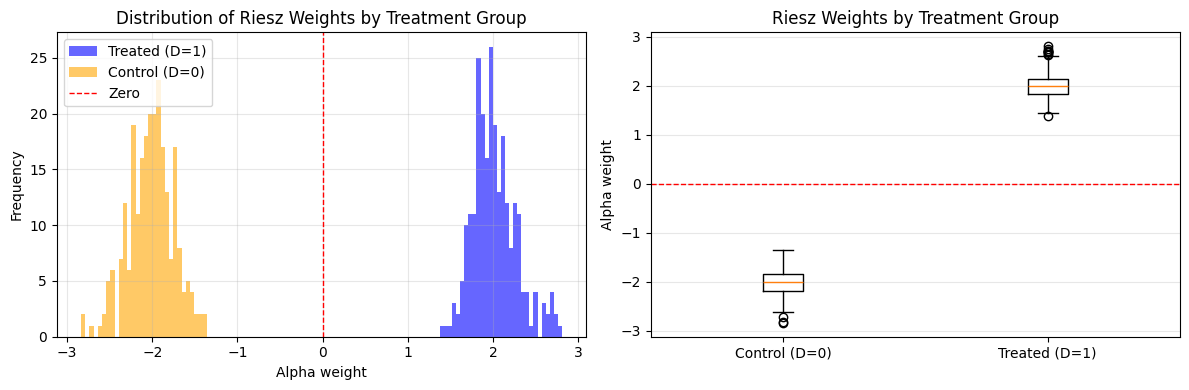

Mean alpha | Treated: 2.015805
Mean alpha | Control: -2.015056


In [27]:
# Visualize alpha weights by treatment group
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Split by treatment status
treated = D == 1
control = D == 0

# Histogram
axes[0].hist(alpha_weights[treated], alpha=0.6, bins=30, label='Treated (D=1)', color='blue')
axes[0].hist(alpha_weights[control], alpha=0.6, bins=30, label='Control (D=0)', color='orange')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')
axes[0].set_xlabel('Alpha weight')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Riesz Weights by Treatment Group')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot([alpha_weights[control], alpha_weights[treated]], 
                 labels=['Control (D=0)', 'Treated (D=1)'])
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_ylabel('Alpha weight')
axes[1].set_title('Riesz Weights by Treatment Group')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Mean alpha | Treated: {alpha_weights[treated].mean():.6f}")
print(f"Mean alpha | Control: {alpha_weights[control].mean():.6f}")

In [29]:
# Understanding how the weights achieve balance
print("How Riesz weights achieve covariate balance:")
print("=" * 60)

# The weights are created by solving: find alpha(x) = basis(x)^T * beta
# such that E[alpha(X) * m(X, gamma)] ≈ E[alpha(X) * Y]

# For ATE: the weights satisfy an*"influence function" property
# Let's verify this by looking at weighted covariate means

basis_vals = basis(X)  # shape (n, 6)
print(f"\nBasis shape: {basis_vals.shape}")

# Unweighted means by group
print("\nUnweighted covariate means:")
print(f"  Control (D=0): Z = {Z[control].mean(axis=0)}")
print(f"  Treated (D=1): Z = {Z[treated].mean(axis=0)}")

# Weighted by alpha
print("\nWeighted by alpha (treated group):")
w_treated = alpha_weights[treated]
w_treated_normalized = w_treated / w_treated.sum()
print(f"  Z = {(Z[treated] * w_treated_normalized[:, None]).sum(axis=0)}")

print("\nWeighted by alpha (control group):")
w_control = alpha_weights[control]
w_control_normalized = w_control / w_control.sum()
print(f"  Z = {(Z[control] * w_control_normalized[:, None]).sum(axis=0)}")

print("\n→ The weights DON'T make the two groups' covariates identical.")
print("→ Instead, they make basis(X) weighted by alpha(X) satisfy a balance condition:")
print("  E[alpha(X) * basis(X)] relates to the functional in a specific way.")
print("\n→ For Riesz weighting, the key property is:")
print("  E[alpha(X) * m(X, gamma)] ≈ E[alpha(X) * Y]")
print("  This is what makes the IPW-style estimator work!")

How Riesz weights achieve covariate balance:

Basis shape: (500, 6)

Unweighted covariate means:
  Control (D=0): Z = [-0.18651897  0.05173549]
  Treated (D=1): Z = [ 0.01089399 -0.06822362]

Weighted by alpha (treated group):
  Z = [-0.09225872 -0.00570434]

Weighted by alpha (control group):
  Z = [-0.08882194 -0.01474376]

→ The weights DON'T make the two groups' covariates identical.
→ Instead, they make basis(X) weighted by alpha(X) satisfy a balance condition:
  E[alpha(X) * basis(X)] relates to the functional in a specific way.

→ For Riesz weighting, the key property is:
  E[alpha(X) * m(X, gamma)] ≈ E[alpha(X) * Y]
  This is what makes the IPW-style estimator work!


In [31]:
# Check train/test covariate distributions in cross-fitting
print("Train/Test Distribution Differences (with cross-fitting):")
print("=" * 60)

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_num = 0

for train_idx, test_idx in kf.split(X):
    fold_num += 1
    X_train, X_test = X[train_idx], X[test_idx]
    Z_train, Z_test = Z[train_idx], Z[test_idx]
    D_train, D_test = D[train_idx], D[test_idx]
    
    print(f"\nFold {fold_num}:")
    print(f"  Train size: {len(train_idx)}, Test size: {len(test_idx)}")
    print(f"  Z mean (train): {Z_train.mean(axis=0)}")
    print(f"  Z mean (test):  {Z_test.mean(axis=0)}")
    print(f"  Z mean diff:    {np.abs(Z_train.mean(axis=0) - Z_test.mean(axis=0))}")
    print(f"  Treatment rate (train): {D_train.mean():.3f}, (test): {D_test.mean():.3f}")

print("\n→ Train and test distributions are NOT identical (finite sample variation)")
print("→ But they come from the SAME population - this is normal")
print("→ Cross-fitting helps remove bias by using separate data for:")
print("    1) Training the model (train set)")
print("    2) Evaluating the functional (test set)")

Train/Test Distribution Differences (with cross-fitting):

Fold 1:
  Train size: 400, Test size: 100
  Z mean (train): [-0.09296866  0.01993979]
  Z mean (test):  [-0.06718781 -0.12097948]
  Z mean diff:    [0.02578085 0.14091927]
  Treatment rate (train): 0.492, (test): 0.530

Fold 2:
  Train size: 400, Test size: 100
  Z mean (train): [-0.10751711 -0.04666757]
  Z mean (test):  [-0.008994    0.14544994]
  Z mean diff:    [0.0985231  0.19211751]
  Treatment rate (train): 0.502, (test): 0.490

Fold 3:
  Train size: 400, Test size: 100
  Z mean (train): [-0.06703898 -0.01953022]
  Z mean (test):  [-0.17090651  0.03690057]
  Z mean diff:    [0.10386752 0.05643079]
  Treatment rate (train): 0.502, (test): 0.490

Fold 4:
  Train size: 400, Test size: 100
  Z mean (train): [-0.10745593  0.02129137]
  Z mean (test):  [-0.00923872 -0.1263858 ]
  Z mean diff:    [0.09821721 0.14767717]
  Treatment rate (train): 0.515, (test): 0.440

Fold 5:
  Train size: 400, Test size: 100
  Z mean (train): [

In [33]:
# Weights fit on BOTH train and test with DIFFERENT distributions
print("Weights fit on pooled train+test (different distributions):")
print("=" * 60)

from genriesz import GRR, ATEFunctional

rng_new = np.random.default_rng(42)

# TRAIN: centered around 0
n_train = 300
Z_train = rng_new.normal(loc=0, scale=1.0, size=(n_train, 2))
D_train = rng_new.binomial(1, 0.5, size=n_train)
Y_train = 1.0 + Z_train[:, 0] + 2.0 * D_train + rng_new.normal(0, 0.5, size=n_train)
X_train_new = np.column_stack([D_train, Z_train])

# TEST: shifted to different location (domain shift)
n_test = 200
Z_test = rng_new.normal(loc=2.0, scale=1.5, size=(n_test, 2))
D_test = rng_new.binomial(1, 0.3, size=n_test)
Y_test = 1.0 + Z_test[:, 0] + 2.0 * D_test + rng_new.normal(0, 0.5, size=n_test)
X_test_new = np.column_stack([D_test, Z_test])

print("\nTrain vs Test distributions:")
print(f"Train: Z_mean={Z_train.mean(axis=0)}, P(D=1)={D_train.mean():.2f}")
print(f"Test:  Z_mean={Z_test.mean(axis=0)}, P(D=1)={D_test.mean():.2f}")
print(f"→ Very different distributions!")

# POOL train and test - fit weights on BOTH
X_pooled = np.vstack([X_train_new, X_test_new])
Y_pooled = np.concatenate([Y_train, Y_test])

m = ATEFunctional(treatment_index=0)
model = GRR(basis=basis, m=m, generator=SquaredGenerator(C=0.0).as_generator())
model.fit(X_pooled)  # Fit on pooled data

# Get weights for each observation
alpha_pooled = model.predict_alpha(X_pooled)
alpha_train_pooled = alpha_pooled[:n_train]
alpha_test_pooled = alpha_pooled[n_train:]

# Compute ATE on each portion
ate_rw_train = np.mean(alpha_train_pooled * Y_train)
ate_rw_test = np.mean(alpha_test_pooled * Y_test)

print(f"\nWeights fit on pooled data:")
print(f"  Weights on train: mean α = {alpha_train_pooled.mean():.4f}")
print(f"  Weights on test:  mean α = {alpha_test_pooled.mean():.4f}")
print(f"\nATE estimates:")
print(f"  Train portion: {ate_rw_train:.4f}")
print(f"  Test portion:  {ate_rw_test:.4f}")
print(f"  Pooled:        {np.mean(alpha_pooled * Y_pooled):.4f}")
print(f"  True effect:   2.0")

# Compare to fitting separately
model_train_only = GRR(basis=basis, m=m, generator=SquaredGenerator(C=0.0).as_generator())
model_train_only.fit(X_train_new)
ate_train_only = model_train_only.estimate_linear_functional(Y_train, X_train_new)

print(f"\nFitted on TRAIN only (for comparison): {ate_train_only:.4f}")
print(f"→ Pooling both groups changes the weight solution!")


Weights fit on pooled train+test (different distributions):

Train vs Test distributions:
Train: Z_mean=[-0.02232775 -0.03000299], P(D=1)=0.49
Test:  Z_mean=[1.87712055 1.91982979], P(D=1)=0.35
→ Very different distributions!

Weights fit on pooled data:
  Weights on train: mean α = 0.1514
  Weights on test:  mean α = -0.2270

ATE estimates:
  Train portion: 2.4619
  Test portion:  1.5083
  Pooled:        2.0804
  True effect:   2.0

Fitted on TRAIN only (for comparison): 2.0147
→ Pooling both groups changes the weight solution!


Alpha weights from pooled train+test model:

TRAIN weights (n=300):
  Mean: 0.151361
  Std:  2.024404
  Min:  -1.946028
  Max:  2.533365
  First 10: [-1.83635481  2.33728075 -1.9304117   2.22609594  2.18831741  2.33966027
  2.29159611 -1.82464965 -1.83144584 -1.78436457]

TEST weights (n=200):
  Mean: -0.227047
  Std:  1.999426
  Min:  -1.905317
  Max:  2.766478
  First 10: [-1.54813857  2.6345652  -1.6645852  -1.80013412  2.46140191 -1.71477553
  2.35591099  2.55043601 -1.62178812 -1.71572716]


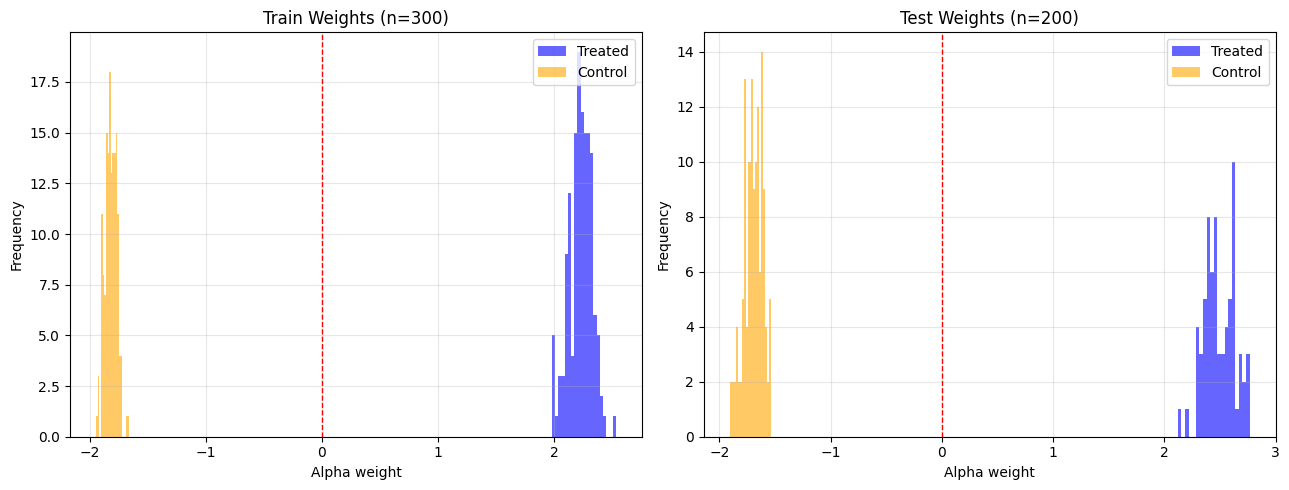


Comparison by treatment group:
Train treated:  mean α = 2.228953
Train control:  mean α = -1.818305
Test treated:   mean α = 2.493902
Test control:   mean α = -1.692174


In [35]:
# Display alpha weights from the pooled model
print("Alpha weights from pooled train+test model:")
print("=" * 60)

print(f"\nTRAIN weights (n={n_train}):")
print(f"  Mean: {alpha_train_pooled.mean():.6f}")
print(f"  Std:  {alpha_train_pooled.std():.6f}")
print(f"  Min:  {alpha_train_pooled.min():.6f}")
print(f"  Max:  {alpha_train_pooled.max():.6f}")
print(f"  First 10: {alpha_train_pooled[:10]}")

print(f"\nTEST weights (n={n_test}):")
print(f"  Mean: {alpha_test_pooled.mean():.6f}")
print(f"  Std:  {alpha_test_pooled.std():.6f}")
print(f"  Min:  {alpha_test_pooled.min():.6f}")
print(f"  Max:  {alpha_test_pooled.max():.6f}")
print(f"  First 10: {alpha_test_pooled[:10]}")

# Visualize distribution by treatment group
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Train weights
train_treated = D_train == 1
train_control = D_train == 0
axes[0].hist(alpha_train_pooled[train_treated], alpha=0.6, bins=20, label='Treated', color='blue')
axes[0].hist(alpha_train_pooled[train_control], alpha=0.6, bins=20, label='Control', color='orange')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Alpha weight')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Train Weights (n={n_train})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test weights
test_treated = D_test == 1
test_control = D_test == 0
axes[1].hist(alpha_test_pooled[test_treated], alpha=0.6, bins=20, label='Treated', color='blue')
axes[1].hist(alpha_test_pooled[test_control], alpha=0.6, bins=20, label='Control', color='orange')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Alpha weight')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Test Weights (n={n_test})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison by treatment group:")
print(f"Train treated:  mean α = {alpha_train_pooled[train_treated].mean():.6f}")
print(f"Train control:  mean α = {alpha_train_pooled[train_control].mean():.6f}")
print(f"Test treated:   mean α = {alpha_test_pooled[test_treated].mean():.6f}")
print(f"Test control:   mean α = {alpha_test_pooled[test_control].mean():.6f}")

In [46]:
# 1. Define your data
X_src = np.random.normal(0, 1, (100, 2))  # Training features (Source)
Y_src = np.random.normal(0, 1, 100)       # Training labels
X_target = np.random.normal(2, 1.5, (50, 2))  # Testing features (Target)

# 2. Define the functional 'm' for Covariate Shift
# This tells the Riesz representer to target the test set distribution
def m_covariate_shift(x_ignored, gamma):
    # This evaluates the outcome model on the test set
    return np.mean([gamma(x) for x in X_target])

# 3. Initialize the Squared Generator
# g(alpha) = (alpha - C)^2. C is typically 0 for standard Riesz/LSIF.
generator = SquaredGenerator(C=0.0).as_generator()

# 4. Set up the Riesz Regression (GRR)
# PolynomialBasis(degree=2) captures interactions for the shift
basis = PolynomialBasis(degree=2)

# riesz_lam is the Ridge penalty (lambda) for weight stability
grr = GRR(basis=basis, 
          m=m_covariate_shift, 
          generator=generator, 
          lam=0.01)

# 5. Fit using the SOURCE data (Training set)
grr.fit(X_src)

# 6. Extract weights for the Training set
train_weights = grr.predict_alpha(X_src)

# 7. (Optional) Diagnostic: The mean of weights should be near 1.0
print(f"Mean Training Weight: {np.mean(train_weights):.4f}")

Mean Training Weight: 1.1043


In [47]:
grr.

array([ 2.18998239e+00, -5.60221148e+00, -4.79789898e+00,  3.07250375e+00,
       -2.13749908e+00, -3.71997136e+00,  4.91902300e+00, -2.81548747e+00,
       -6.04123367e+00, -5.78650332e+00,  2.45412118e+01, -4.59218211e+00,
        8.31425906e+00, -4.84592402e+00,  1.17383219e+01,  8.63567736e+00,
       -3.89070123e+00, -2.10958838e+00, -6.04340621e+00, -6.57193520e+00,
       -4.90517991e+00, -6.66780158e+00,  2.01129470e+01, -1.05368736e+00,
        2.08700925e+01, -3.02372193e+00, -6.50800735e+00,  9.15953193e+00,
        5.61702997e+00, -5.09456428e+00,  9.05495912e-01, -5.12427622e+00,
        7.93162770e+00,  1.18965841e+01, -1.85536069e+00, -5.15239673e+00,
       -7.08878148e+00,  1.18030192e+01, -5.33905571e+00,  3.88175613e+00,
       -5.61983468e+00, -5.17542509e+00, -4.02706115e+00,  2.78473230e+00,
       -4.93406147e+00,  9.55488472e+00,  1.05588538e+01, -6.27918863e+00,
        4.60402026e+00, -5.76754409e+00, -4.88738674e+00,  1.68873334e-01,
       -2.79146525e+00, -

---

In [65]:
import numpy as np
import pandas as pd
from genriesz import grr_functional, SquaredGenerator, PolynomialBasis

In [50]:
# The training data (Source)
X_train = np.random.normal(0, 1, (400, 2))  # shape (400, features)
Y_train = np.random.normal(0, 1, 400)       # shape (400,)

# The testing data (Target)
X_test = np.random.normal(2, 1.5, (300, 2))  # shape (300, features)

# CORRECT way to define m for Covariate Shift in genriesz
def m_covariate_shift(x, gamma):
    # 'x' is the batch the solver provides (e.g., the 80 samples from a fold)
    # But for covariate shift, we ALWAYS want the mean over the 300 target samples.
    # We use the global X_test here.
    preds = np.array([gamma(xi) for xi in X_test])
    return np.mean(preds)

# Now run the functional
results = grr_functional(
    X=X_train, 
    Y=Y_train,
    m=m_covariate_shift,
    basis=PolynomialBasis(degree=2),
    generator=SquaredGenerator().as_generator(),
    cross_fit=True, # The length mismatch usually happens here
    folds=5
)

In [51]:
results.summary_text()

'n=400, cross_fit=True, folds=5, alpha=0.05, null=0.0\n AIPW (shared):  0.322264  (se=0.327282)  CI[95%]=-0.319197,0.963725  p=0.3248\n   DM (shared):  0.565394  (se=0.004686)  CI[95%]=0.556211,0.574578  p=0\n           IPW:  0.723174  (se=0.454456)  CI[95%]=-0.167544,1.613892  p=0.1115'

In [73]:
results.alpha_hat

array([-9.07476380e-01, -1.29760332e+00, -1.71414364e+00, -1.75360108e+00,
       -2.65184961e+00, -3.14619860e+00,  4.93179709e+00, -3.22000424e+00,
       -5.39301660e-01,  9.67300915e+00,  8.73677631e-01, -1.02560672e+00,
       -1.77838367e+00, -6.56187250e-01, -3.87470429e-01,  1.94982339e+00,
        1.94957588e+01,  4.42602652e-01,  3.58455735e+01,  3.42721567e+00,
        3.40359974e+00, -2.43426757e+00, -2.00476564e-01, -1.36842378e+00,
       -3.01916266e+00,  3.55108856e+00,  5.37136029e+00,  8.60617932e+00,
       -4.66040219e-01, -2.72544367e+00, -9.25982370e-02, -2.03832200e+00,
       -3.06859396e+00, -7.79348332e-01,  6.68941158e+00, -3.31661324e+00,
        6.02615005e+00, -1.53067778e+00, -2.03790153e+00, -3.02804227e+00,
        4.07453556e+00, -3.38560421e+00, -3.44855760e+00, -2.69066755e+00,
        5.23872984e+00,  7.04237275e-01,  2.73359190e+00, -3.33610249e+00,
        2.31493434e+01, -1.20929554e+00,  1.21820060e+00, -2.56387677e+00,
       -2.80961838e+00, -

In [74]:
X_train_frame = pd.DataFrame(X_train, columns=['Feature1', 'Feature2'])
X_test_frame = pd.DataFrame(X_test, columns=['Feature1', 'Feature2'])

In [75]:
# Propensity score / weights function

X_train_frame["AV_label"] = 0
X_test_frame["AV_label"]  = 1

all_data = pd.concat([X_train_frame, X_test_frame], axis=0).reset_index(drop=True)
X_features = all_data[all_data.columns.difference(['AV_label'])]
y_labels = all_data["AV_label"]

prop_scores = np.zeros(len(all_data))

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in cv_strategy.split(X_features, y_labels):
    model = xgb.XGBClassifier(
        eval_metric='logloss', 
        max_depth=3, 
        learning_rate=0.05,
        n_estimators=100,
        random_state=42
    )
    model.fit(X_features.iloc[train_idx], y_labels.iloc[train_idx])
    
    prop_scores[val_idx] = model.predict_proba(X_features.iloc[val_idx])[:, 1]
    # Propensity scores

# prob_train_in_test as probability for training obs: probability that obs is from test set
prob_train_in_test = prop_scores[:len(X_train_frame)]
initial_weights = prob_train_in_test / (1 - prob_train_in_test)

In [76]:
initial_weights

array([2.40134357e-02, 2.95341940e-02, 2.07663189e-01, 1.68522538e-01,
       3.93807367e-02, 2.90862797e-02, 5.58988636e-01, 2.32192305e-02,
       2.10378902e-02, 3.72337021e-01, 1.91365830e-01, 2.43886927e-01,
       2.66034264e-02, 8.08235093e-02, 8.08235093e-02, 1.78131287e-01,
       4.71627316e+00, 1.25078970e-01, 2.40134357e-02, 4.02967702e-01,
       1.60684122e-01, 3.57443454e-02, 5.96164919e-02, 1.37491546e-01,
       2.76693634e-02, 3.35747845e-01, 5.43769990e-01, 1.80922389e+00,
       5.05729216e-02, 3.89801297e-02, 4.36195399e-01, 2.25737900e-02,
       3.87081629e-02, 1.26522957e-01, 3.81548312e-01, 3.87081629e-02,
       2.18194024e-01, 3.01395522e-02, 1.55678482e-02, 4.73331347e-02,
       2.12248287e+00, 3.53191348e-02, 3.76909182e-02, 7.34701330e-02,
       4.67851428e-02, 1.77319513e-01, 4.52650289e-01, 3.79071537e-02,
       3.89459585e+00, 3.06320439e-02, 3.29192958e-02, 2.55441090e-01,
       2.92418368e-02, 1.47066546e-02, 4.10575048e-01, 6.25356347e-02,
      

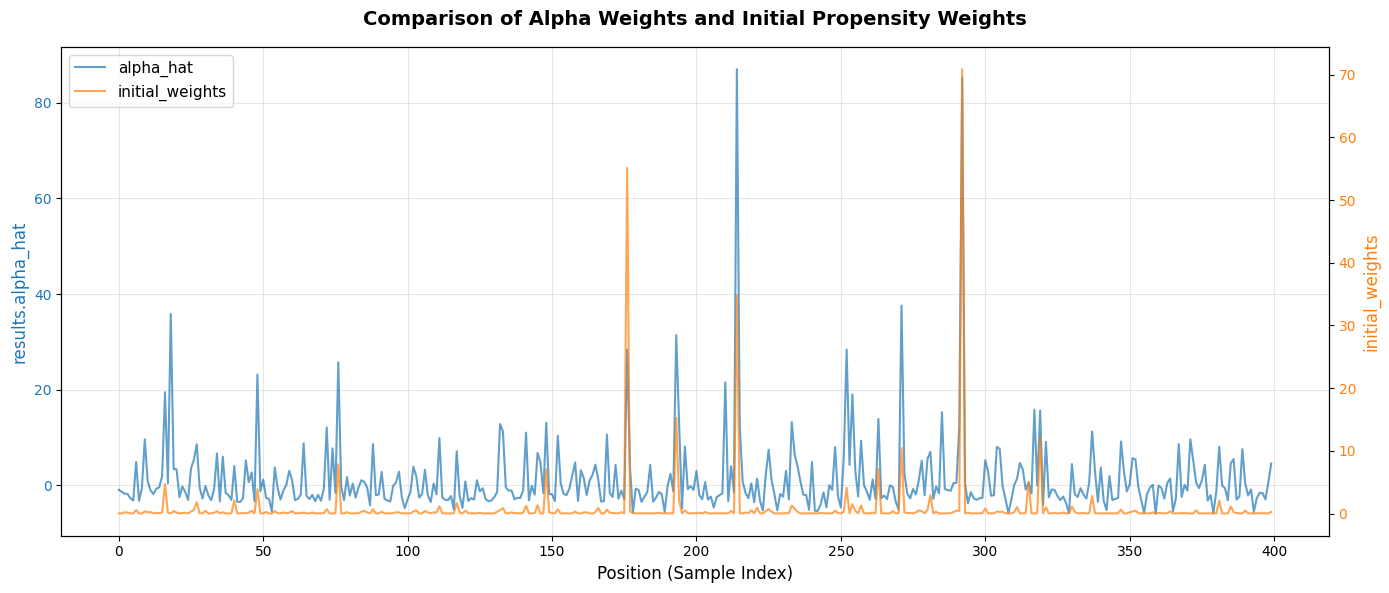

Statistics:
alpha_hat - Mean: 1.248212, Std: 8.497100
initial_weights - Mean: 0.780610, Std: 4.958449


In [78]:
# Plot results.alpha_hat and initial_weights with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

positions = np.arange(len(results.alpha_hat))

# Plot alpha_hat on the left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Position (Sample Index)', fontsize=12)
ax1.set_ylabel('results.alpha_hat', color=color1, fontsize=12)
line1 = ax1.plot(positions, results.alpha_hat, color=color1, alpha=0.7, linewidth=1.5, label='alpha_hat')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create a second y-axis for initial_weights
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('initial_weights', color=color2, fontsize=12)
line2 = ax2.plot(positions, initial_weights, color=color2, alpha=0.7, linewidth=1.5, label='initial_weights')
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and legend
fig.suptitle('Comparison of Alpha Weights and Initial Propensity Weights', fontsize=14, fontweight='bold')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

# Print some statistics
print("Statistics:")
print(f"alpha_hat - Mean: {np.mean(results.alpha_hat):.6f}, Std: {np.std(results.alpha_hat):.6f}")
print(f"initial_weights - Mean: {np.mean(initial_weights):.6f}, Std: {np.std(initial_weights):.6f}")